In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [51]:
# file = "sat-data.h5"
# sat_data = pd.read_hdf(file)
filex = "sat-data.npy"
filey = "sat-labels.npy"

sat_data = np.load( filex )
sat_labels = np.load( filey, allow_pickle=True )

In [52]:
sat_data = sat_data.astype('float32')
sat_labels = np.array([label[0] for label in sat_labels]).astype('int32')

In [53]:
sat_data.shape, sat_labels.shape

((104, 20, 6), (104, 3))

In [54]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sat_data, sat_labels, test_size=0.2, random_state=42)

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Softmax, Conv1D, MaxPooling1D
import tensorflow as tf

class SequentialNN(tf.keras.models.Sequential):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def predict(self, x):
        pred_probs = super().predict(x)
        rounded_probs = tf.math.round(pred_probs)
        predictions = tf.cast(rounded_probs, tf.int32).numpy()
        return predictions.flatten()
    
# Define the CNN model
model = SequentialNN()

# input_shape = (20, 6, 1)
# First convolutional layer (assuming 1D data)
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

# Second convolutional layer
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))

# Max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(units=192, activation='relu'))
model.add(Dense(units=89, activation='relu'))

# Output layer with 3 units for maneuver classification (no maneuver, beginning of maneuver, during maneuver) not float but integer
model.add(Dense(units=3, activation='softmax'))

# # Output layer with 3 output units for classification, [1, 0, 0], [0, 1, 0], [0, 0, 1] sigmoid activation function
# model.add(Dense(units=3, activation='sigmoid'))

# Compile the model (loss function and optimizer might be different in the paper)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Implement 10-fold cross-validation (code not shown here, refer to Kera's documentation)
model.build(input_shape=sat_data.shape)

model.summary()
# Train the model (refer to Keras documentation for training with validation sets)
# model.fit(X_train, y_train, epochs=5)


Model: "sequential_nn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (104, 19, 128)            1664      
                                                                 
 conv1d_3 (Conv1D)           (104, 18, 128)            32896     
                                                                 
 max_pooling1d_1 (MaxPoolin  (104, 9, 128)             0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (104, 1152)               0         
                                                                 
 dense_3 (Dense)             (104, 192)                221376    
                                                                 
 dense_4 (Dense)             (104, 89)                 17177     
                                                   

In [56]:
sat_labels[0]

array([1, 0, 0], dtype=int32)

In [57]:
sat_data.shape

(104, 20, 6)

In [58]:
flattened_data = []
for x in X_train:
    x.flatten()
    flattened_data.append(x.flatten())

flattened_data = np.array(flattened_data)
flattened_data.shape

(83, 120)

In [59]:
flattened_y = []
for y in y_train:
    if y[0] == 1:
        flattened_y.append(0)
    elif y[1] == 1:
        flattened_y.append(1)
    elif y[2] == 1:
        flattened_y.append(2)
    
flattened_y = np.array(flattened_y)
flattened_y.shape

(83,)

In [60]:

history = model.fit(sat_data, sat_labels, epochs=30, batch_size=32, validation_split=0.3)

Epoch 1/30


3/3 [==============================] - 0s 42ms/step - loss: 1.0147 - accuracy: 0.5556 - val_loss: 0.9367 - val_accuracy: 0.7812
Epoch 2/30
3/3 [==============================] - 0s 9ms/step - loss: 0.6827 - accuracy: 0.8056 - val_loss: 0.9090 - val_accuracy: 0.7812
Epoch 3/30
3/3 [==============================] - 0s 8ms/step - loss: 0.4233 - accuracy: 0.9028 - val_loss: 1.2401 - val_accuracy: 0.7812
Epoch 4/30
3/3 [==============================] - 0s 9ms/step - loss: 0.2544 - accuracy: 0.8750 - val_loss: 1.6916 - val_accuracy: 0.7812
Epoch 5/30
3/3 [==============================] - 0s 9ms/step - loss: 0.1380 - accuracy: 0.9306 - val_loss: 2.2246 - val_accuracy: 0.7812
Epoch 6/30
3/3 [==============================] - 0s 9ms/step - loss: 0.0669 - accuracy: 1.0000 - val_loss: 2.8834 - val_accuracy: 0.7812
Epoch 7/30
3/3 [==============================] - 0s 8ms/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 3.2193 - val_accuracy: 0.7812
Epoch 8/30
3/3 [============================

In [61]:
# Evaluate the model
# model.evaluate(X_test, y_test)
model.evaluate(sat_data, sat_labels)
# show trustworthiness of the model


# show trustworthiness of the model
# model.predict(X_test)
model.predict(sat_data[:1])

model.evaluate(X_test, y_test)


1/1 [==============================] - 0s 13ms/step - loss: 0.9626 - accuracy: 0.9524


[0.9625715613365173, 0.9523809552192688]

In [62]:
# Save the model
model.save("trustee_model.h5")

/Users/nairda/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [63]:
# export train and test data
np.save("train_data.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("test_data.npy", X_test)
np.save("test_labels.npy", y_test)

In [64]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

y_pred = []
for x in sat_data:
    x = x.reshape(1, 20, 6)
    y_pred.append(model.predict(x))

# confusion_matrix(sat_labels, y_pred)



1/1 [==============================] - 0s 10ms/step


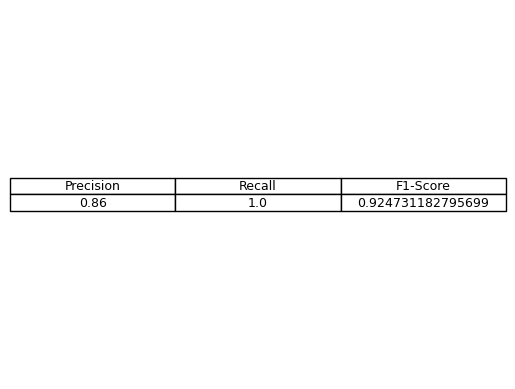

In [65]:
precision_recall_fscore_support(sat_labels, y_pred, average='weighted')

import matplotlib.pyplot as plt

# plot table for precision_recall_fscore for each class
precision, recall, fscore, support = precision_recall_fscore_support(sat_labels, y_pred)

# subplots column mlmethod f1, precision, recall columns with df
import pandas as pd

# Assuming precision, recall, fscore are calculated as follows:
# precision, recall, fscore, support = precision_recall_fscore_support(sat_labels, y_pred)

# Create a dictionary with the metrics
data = {'Precision': precision[0], 'Recall': recall[0], 'F1-Score': fscore[0]}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data, index=['No Maneuver'])

# Plot the DataFrame as a table
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center', colLoc='center')
plt.show()



In [66]:
import pandas as pd

# Assuming precision, recall, fscore are calculated as follows:
# precision, recall, fscore, support = precision_recall_fscore_support(sat_labels, y_pred)

# Create a dictionary with the metrics
data = {'Precision': precision, 'Recall': recall, 'F1-Score': fscore}

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)

   Precision    Recall  F1-Score
0       0.86  1.000000  0.924731
1       1.00  1.000000  1.000000
2       1.00  0.766667  0.867925


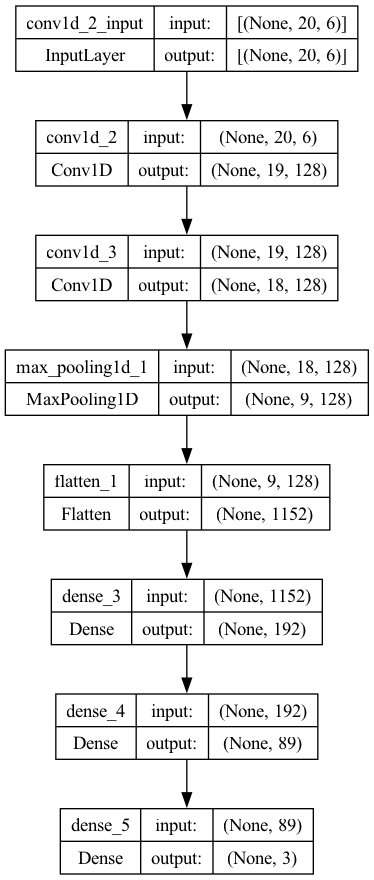

In [67]:
tf.keras.utils.plot_model(model, show_shapes=True)

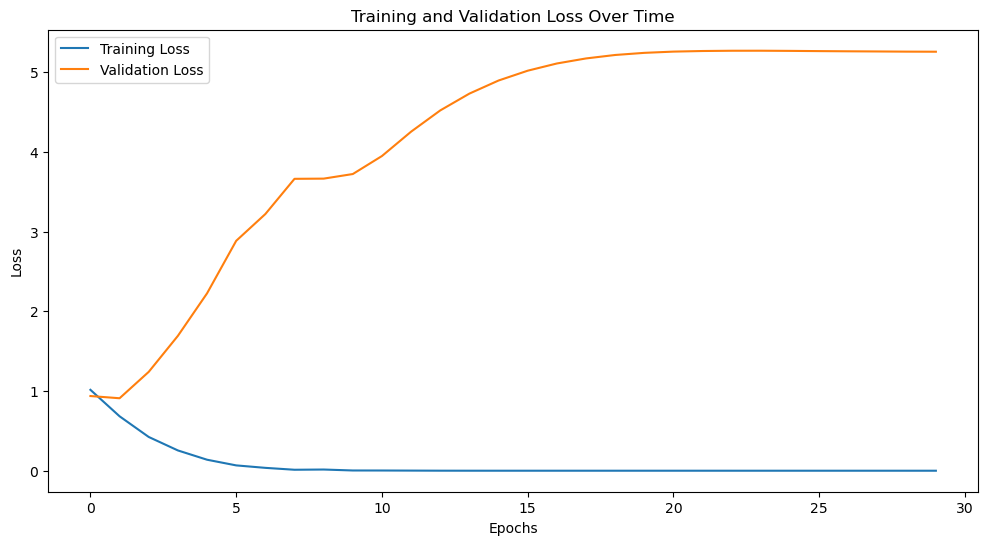

<Figure size 640x480 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('loss_plot.png')